In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import pandas as pd
import requests
import glob

### Data Loading

In [2]:
trip_files = glob.glob("./202510-citibike-tripdata/*")

In [3]:
df = pd.concat([ 
    pd.read_csv(
        tf,
        parse_dates=["started_at", "ended_at"],
        dtype={
            "start_station_name": str,
            "end_station_name": str,
            "start_station_id": str,
            "end_station_id": str
        }
    ) for tf in trip_files
])

In [4]:
df.shape

(4731900, 13)

In [5]:
df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,557FE56828BC7B72,electric_bike,2025-10-02 14:01:28.598,2025-10-02 14:06:46.526,E 2 St & 2 Ave,5593.02,Pike St & E Broadway,5270.05,40.725029,-73.990697,40.714067,-73.992939,member
1,0C147B351D46C123,electric_bike,2025-10-04 19:10:31.195,2025-10-04 19:11:42.659,4 Ave & 9 St,3955.05,4 Ave & 9 St,3955.05,40.670513,-73.988766,40.670513,-73.988766,member
2,F95C5036724DB9E8,electric_bike,2025-10-01 16:33:41.956,2025-10-01 16:47:40.976,Pier 40 - Hudson River Park,5696.03,Pike St & E Broadway,5270.05,40.727714,-74.011296,40.714067,-73.992939,member
3,2E0404A1CDF25730,electric_bike,2025-10-06 01:00:01.922,2025-10-06 01:25:45.023,1 Ave & E 30 St,6079.03,1 Ave & E 30 St,6079.03,40.741444,-73.975361,40.741444,-73.975361,member
4,33F394645EF291E3,classic_bike,2025-10-06 18:47:27.905,2025-10-06 18:54:54.480,74 St & 37 Ave,6332.06,77 St & 31 Ave,6718.02,40.749080,-73.891720,40.758860,-73.890810,member


### Add Additional Information

We are going to cluster stations on the following attributes:

- percentage of weekend start / ends
- percentage of commuting hour start / ends (defining that as 7-9 am and 5-7 pm)
- percentage of member vs. casual start / ends
- percentage of classic vs. electric start / ends
- average ride time for departing / arriving start / ends
- total number of start / ends

In order to make generating some of these data points easier we will add some metadata columns.

In [7]:
# weekday of datetime is 0 - Monday through 6 - Sunday
df['is_weekend_start'] = df['started_at'].apply(lambda x: x.weekday() in [5,6])
df['is_weekend_end'] = df['ended_at'].apply(lambda x: x.weekday() in [5,6])

In [8]:
df['is_weekend_start'].value_counts(normalize=True)

is_weekend_start
False    0.754737
True     0.245263
Name: proportion, dtype: float64

In [9]:
# hour uses a 24-hour clock so this is any time starting in the 7 or 8 am hour or 5 or 6 pm hours
df['is_commute_start'] = df.apply(lambda x:  (not x['is_weekend_start']) and (x['started_at'].hour in [7,8,17,18]), axis=1)

In [10]:
df['is_commute_end'] = df.apply(lambda x: (not x['is_weekend_end']) and (x['ended_at'].hour in [7,8,17,18]), axis=1)

In [11]:
# this is to just make sure we're doing this correctly
df.sample(10)[['started_at', 'is_weekend_start', 'is_commute_start', 'ended_at', 'is_weekend_end', 'is_commute_end']]

,started_at,is_weekend_start,is_commute_start,ended_at,is_weekend_end,is_commute_end
52607,2025-10-16 02:48:37.352,False,False,2025-10-16 03:00:00.700,False,False
535800,2025-10-21 02:36:37.759,False,False,2025-10-21 02:40:14.064,False,False
126473,2025-10-11 11:53:02.023,True,False,2025-10-11 12:04:17.966,True,False
342562,2025-10-08 18:25:05.680,False,True,2025-10-08 18:29:57.805,False,True
422769,2025-10-09 13:46:55.365,False,False,2025-10-09 13:53:14.424,False,False
225908,2025-10-24 17:05:24.773,False,True,2025-10-24 17:14:19.104,False,True
4516,2025-10-03 09:21:18.611,False,False,2025-10-03 09:28:19.187,False,False
988736,2025-10-23 08:16:37.917,False,True,2025-10-23 08:45:19.955,False,True
414657,2025-10-25 11:39:38.740,True,False,2025-10-25 12:56:52.051,True,False
171639,2025-10-28 17:49:13.561,False,True,2025-10-28 17:56:09.934,False,True


In [12]:
df['total_ride_time'] = df.apply(lambda x: x['ended_at'] - x['started_at'], axis=1)

In [13]:
df.head()['total_ride_time']

0   0 days 00:05:17.928000
1   0 days 00:01:11.464000
2   0 days 00:13:59.020000
3   0 days 00:25:43.101000
4   0 days 00:07:26.575000
Name: total_ride_time, dtype: timedelta64[ns]

In [14]:
df.total_ride_time.dtype

dtype('<m8[ns]')

### Reframe Data To Be About Stations

In [15]:
# only trips that start and end
df_trips_start_end = df.loc[lambda x: ~x['started_at'].isnull() & ~x['ended_at'].isnull()].copy()

In [16]:
df_trips_start_end.shape

(4731900, 18)

In [17]:
start_groupby = (
    df_trips_start_end
    .groupby('start_station_id')
    .pipe(lambda grp:
        pd.DataFrame({
            'total_rides': grp.size(),
            'weekend_rides': grp['is_weekend_start'].sum(),
            'commute_rides': grp['is_commute_start'].sum(),
            'average_ride_time': grp['total_ride_time'].mean(),
            'electric_rides': grp['rideable_type'].apply(lambda x: (x == 'electric_bike').sum()),
            'member_rides': grp['member_casual'].apply(lambda x: (x == 'member').sum())
        })
    )
    .assign(pct_weekend=lambda df: df.apply(lambda x: x['weekend_rides'] / x['total_rides'], axis=1))
    .assign(pct_commute=lambda df: df.apply(lambda x: x['commute_rides'] / x['total_rides'], axis=1))
    .assign(pct_electric=lambda df: df.apply(lambda x: x['electric_rides'] / x['total_rides'], axis=1))
    .assign(pct_member=lambda df: df.apply(lambda x: x['member_rides'] / x['total_rides'], axis=1))
)

In [18]:
start_groupby.head()

,total_rides,weekend_rides,commute_rides,average_ride_time,electric_rides,member_rides,pct_weekend,pct_commute,pct_electric,pct_member
start_station_id,,,,,,,,,,
1234.56,165,58,18,0 days 00:16:13.806181818,132,157,0.351515,0.109091,0.800000,0.951515
2261.04,14,0,5,0 days 00:14:23.997500,12,11,0.000000,0.357143,0.857143,0.785714
2312.02,5,0,2,0 days 00:08:50.894000,4,2,0.000000,0.400000,0.800000,0.400000
2387.07,71,24,19,0 days 00:21:21.455014084,41,48,0.338028,0.267606,0.577465,0.676056
2419.03,3,0,0,0 days 00:05:38.590666666,2,1,0.000000,0.000000,0.666667,0.333333


In [19]:
end_groupby = (
    df_trips_start_end
    .groupby('end_station_id')
    .pipe(lambda grp:
        pd.DataFrame({
            'total_rides': grp.size(),
            'weekend_rides': grp['is_weekend_end'].sum(),
            'commute_rides': grp['is_commute_end'].sum(),
            'average_ride_time': grp['total_ride_time'].mean(),
            'electric_rides': grp['rideable_type'].apply(lambda x: (x == 'electric_bike').sum()),
            'member_rides': grp['member_casual'].apply(lambda x: (x == 'member').sum())
        })
    )
    .assign(pct_weekend=lambda df: df.apply(lambda x: x['weekend_rides'] / x['total_rides'], axis=1))
    .assign(pct_commute=lambda df: df.apply(lambda x: x['commute_rides'] / x['total_rides'], axis=1))
    .assign(pct_electric=lambda df: df.apply(lambda x: x['electric_rides'] / x['total_rides'], axis=1))
    .assign(pct_member=lambda df: df.apply(lambda x: x['member_rides'] / x['total_rides'], axis=1))
)

In [20]:
end_groupby.head()

,total_rides,weekend_rides,commute_rides,average_ride_time,electric_rides,member_rides,pct_weekend,pct_commute,pct_electric,pct_member
end_station_id,,,,,,,,,,
1234.56,287,98,31,0 days 00:13:58.127836236,202,275,0.341463,0.108014,0.703833,0.958188
2261.04,20,0,6,0 days 00:23:17.634250,18,14,0.000000,0.300000,0.900000,0.700000
2312.02,14,0,3,0 days 00:14:02.429428571,11,2,0.000000,0.214286,0.785714,0.142857
2387.07,87,28,14,0 days 00:18:04.896850574,57,53,0.321839,0.160920,0.655172,0.609195
2419.03,8,0,3,0 days 00:07:08.200625,5,6,0.000000,0.375000,0.625000,0.750000


In [21]:
# Merge Start and End for a Complete Dataframe and only use stations with starts and end
merged_station_trip_data = start_groupby.join(end_groupby, how='outer', lsuffix='_start', rsuffix='_end').dropna()

In [22]:
# That's still almost 2,200 docks and they look like this
merged_station_trip_data.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,total_rides_end,weekend_rides_end,commute_rides_end,average_ride_time_end,electric_rides_end,member_rides_end,pct_weekend_end,pct_commute_end,pct_electric_end,pct_member_end
1234.56,165.0,58.0,18.0,0 days 00:16:13.806181818,132.0,157.0,0.351515,0.109091,0.800000,0.951515,287,98,31,0 days 00:13:58.127836236,202,275,0.341463,0.108014,0.703833,0.958188
2261.04,14.0,0.0,5.0,0 days 00:14:23.997500,12.0,11.0,0.000000,0.357143,0.857143,0.785714,20,0,6,0 days 00:23:17.634250,18,14,0.000000,0.300000,0.900000,0.700000
2312.02,5.0,0.0,2.0,0 days 00:08:50.894000,4.0,2.0,0.000000,0.400000,0.800000,0.400000,14,0,3,0 days 00:14:02.429428571,11,2,0.000000,0.214286,0.785714,0.142857
2387.07,71.0,24.0,19.0,0 days 00:21:21.455014084,41.0,48.0,0.338028,0.267606,0.577465,0.676056,87,28,14,0 days 00:18:04.896850574,57,53,0.321839,0.160920,0.655172,0.609195
2419.03,3.0,0.0,0.0,0 days 00:05:38.590666666,2.0,1.0,0.000000,0.000000,0.666667,0.333333,8,0,3,0 days 00:07:08.200625,5,6,0.000000,0.375000,0.625000,0.750000


In [23]:
merged_station_trip_data.shape

(2169, 20)

### Station Metadata

We also want to do some mapping, so we'll need the latitude and longitude. We'll have to use the real-time data to get it!

In [24]:
import requests

In [25]:
r_station_information = requests.get("https://gbfs.lyft.com/gbfs/2.3/bkn/es/station_information.json")
station_metadata = pd.DataFrame.from_dict(r_station_information.json().get('data').get('stations'))

In [26]:
station_metadata.head()

,capacity,station_id,short_name,name,rental_uris,lat,lon,region_id
0,20,6542d952-ca19-410e-9290-ee6b7a6e14cf,8664.06,Decatur Ave & Bedford Park Blvd,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.868130,-73.884120,71
1,17,498d7e8e-5164-4f26-9ce6-399947d73b1a,5043.06,Suydam St & St Nicholas Ave,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.706360,-73.919450,71
2,41,a47f77a2-9008-4652-a4f1-b95eee723a1b,6569.08,W 35 St & Dyer Ave,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.754692,-73.997402,71
3,0,2138075988152462096,2818.01,Ditmas Ave & McDonald Ave,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.635480,-73.978250,71
4,37,66db3687-0aca-11e7-82f6-3863bb44ef7c,4829.01,Columbia Heights & Cranberry St,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.700379,-73.995481,71


In [27]:
station_lat_lon = station_metadata[['short_name', 'lat', 'lon']].set_index('short_name')

### End Result

In [28]:
station_trip_meta = merged_station_trip_data.join(station_lat_lon, how='left').dropna()

In [30]:
station_metadata["name"].count()

2308

In [31]:
# turning it into a GeoDataFrame for plotting purposes
g_stations = gpd.GeoDataFrame(
    station_trip_meta,
    geometry=gpd.points_from_xy(station_trip_meta.lon, station_trip_meta.lat),
    crs="EPSG:4326")

### Where Are The Stations?

Before we do any clustering let's see where the stations are.

In [32]:
# Read GeoJSON file
gdf = gpd.read_file("new-york-city-boroughs.geojson")

In [33]:
g_stations = g_stations.to_crs(gdf.crs)

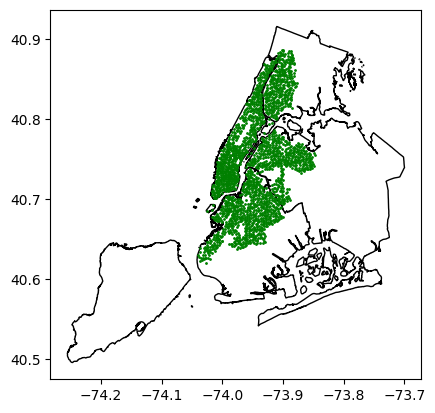

In [34]:
# Plot the data
base = gdf.plot(color='white', edgecolor='black')
g_stations.plot(ax=base, marker='o', color='green', markersize=1)
plt.show()

### Normalize The Data

Percentages are on a scale of 0-1 because K-Means clustering is about distance we want everything else to be on a similar scale. In order to do that we're going to "normalize" a few columns by dividing by the maximum amount in that column.

In [35]:
g_stations.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,...,average_ride_time_end,electric_rides_end,member_rides_end,pct_weekend_end,pct_commute_end,pct_electric_end,pct_member_end,lat,lon,geometry
2261.04,14.0,0.0,5.0,0 days 00:14:23.997500,12.0,11.0,0.000000,0.357143,0.857143,0.785714,...,0 days 00:23:17.634250,18,14,0.000000,0.300000,0.900000,0.700000,40.62021,-74.02717,POINT (-74.02717 40.62021)
2312.02,5.0,0.0,2.0,0 days 00:08:50.894000,4.0,2.0,0.000000,0.400000,0.800000,0.400000,...,0 days 00:14:02.429428571,11,2,0.000000,0.214286,0.785714,0.142857,40.62254,-74.03726,POINT (-74.03726 40.62254)
2387.07,71.0,24.0,19.0,0 days 00:21:21.455014084,41.0,48.0,0.338028,0.267606,0.577465,0.676056,...,0 days 00:18:04.896850574,57,53,0.321839,0.160920,0.655172,0.609195,40.62402,-74.03396,POINT (-74.03396 40.62402)
2419.03,3.0,0.0,0.0,0 days 00:05:38.590666666,2.0,1.0,0.000000,0.000000,0.666667,0.333333,...,0 days 00:07:08.200625,5,6,0.000000,0.375000,0.625000,0.750000,40.62503,-74.03059,POINT (-74.03059 40.62503)
2453.05,53.0,18.0,4.0,0 days 00:15:57.638547169,38.0,32.0,0.339623,0.075472,0.716981,0.603774,...,0 days 00:15:26.993500,44,43,0.453125,0.156250,0.687500,0.671875,40.62643,-74.02707,POINT (-74.02707 40.62643)


In [36]:
columns_to_norm = [
    'total_rides_start',
    'average_ride_time_start',
    'total_rides_end',
    'average_ride_time_end'
]

In [37]:
for c in columns_to_norm:
    g_stations[c + '_norm'] = g_stations[c].apply(lambda x: x / g_stations[c].max())

In [38]:
g_stations.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,...,pct_commute_end,pct_electric_end,pct_member_end,lat,lon,geometry,total_rides_start_norm,average_ride_time_start_norm,total_rides_end_norm,average_ride_time_end_norm
2261.04,14.0,0.0,5.0,0 days 00:14:23.997500,12.0,11.0,0.000000,0.357143,0.857143,0.785714,...,0.300000,0.900000,0.700000,40.62021,-74.02717,POINT (-74.02717 40.62021),0.000772,0.206146,0.001099,0.606433
2312.02,5.0,0.0,2.0,0 days 00:08:50.894000,4.0,2.0,0.000000,0.400000,0.800000,0.400000,...,0.214286,0.785714,0.142857,40.62254,-74.03726,POINT (-74.03726 40.62254),0.000276,0.126669,0.000769,0.365530
2387.07,71.0,24.0,19.0,0 days 00:21:21.455014084,41.0,48.0,0.338028,0.267606,0.577465,0.676056,...,0.160920,0.655172,0.609195,40.62402,-74.03396,POINT (-74.03396 40.62402),0.003918,0.305749,0.004782,0.470737
2419.03,3.0,0.0,0.0,0 days 00:05:38.590666666,2.0,1.0,0.000000,0.000000,0.666667,0.333333,...,0.375000,0.625000,0.750000,40.62503,-74.03059,POINT (-74.03059 40.62503),0.000166,0.080786,0.000440,0.185796
2453.05,53.0,18.0,4.0,0 days 00:15:57.638547169,38.0,32.0,0.339623,0.075472,0.716981,0.603774,...,0.156250,0.687500,0.671875,40.62643,-74.02707,POINT (-74.02707 40.62643),0.002924,0.228488,0.003517,0.402222


In [39]:
g_stations["total_rides_start"].max()

18123.0

### Cluster The Data

1. How many clusters should there be?
2. Actually create the clusters

One way to determine how many clusters there should be is the Elbow Method. Basically you look for the point at which the "inertia" of the clusters starts to go down linearly.

In [40]:
features = [
    'total_rides_start_norm',
    'pct_weekend_start',
    'pct_commute_start',
    'pct_electric_start',
    'pct_member_start',
    'average_ride_time_start_norm',
    'average_ride_time_end_norm',
    'total_rides_end_norm',
    'pct_weekend_end',
    'pct_commute_end',
    'pct_electric_end',
    'pct_member_end'
]

In [41]:
inertias = []

In [42]:
for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(g_stations[features])
    inertias.append(kmeans.inertia_)

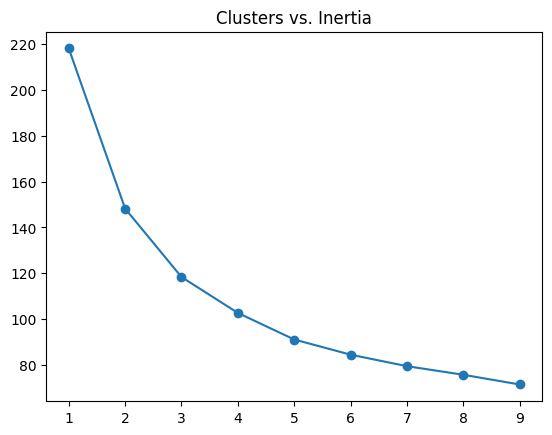

In [43]:
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia')
plt.show()

From the graph above it looks like either 5 or 6 would probably be a good number to use for our clusters. Let's try separating them into 6 clusters!

In [44]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(g_stations[features])

KMeans(n_clusters=6, random_state=42)

In [45]:
kmeans.labels_

array([1, 0, 4, ..., 4, 1, 0], dtype=int32)

In [46]:
g_stations['kmeans_label'] = kmeans.labels_

In [47]:
g_stations.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,...,pct_electric_end,pct_member_end,lat,lon,geometry,total_rides_start_norm,average_ride_time_start_norm,total_rides_end_norm,average_ride_time_end_norm,kmeans_label
2261.04,14.0,0.0,5.0,0 days 00:14:23.997500,12.0,11.0,0.000000,0.357143,0.857143,0.785714,...,0.900000,0.700000,40.62021,-74.02717,POINT (-74.02717 40.62021),0.000772,0.206146,0.001099,0.606433,1
2312.02,5.0,0.0,2.0,0 days 00:08:50.894000,4.0,2.0,0.000000,0.400000,0.800000,0.400000,...,0.785714,0.142857,40.62254,-74.03726,POINT (-74.03726 40.62254),0.000276,0.126669,0.000769,0.365530,0
2387.07,71.0,24.0,19.0,0 days 00:21:21.455014084,41.0,48.0,0.338028,0.267606,0.577465,0.676056,...,0.655172,0.609195,40.62402,-74.03396,POINT (-74.03396 40.62402),0.003918,0.305749,0.004782,0.470737,4
2419.03,3.0,0.0,0.0,0 days 00:05:38.590666666,2.0,1.0,0.000000,0.000000,0.666667,0.333333,...,0.625000,0.750000,40.62503,-74.03059,POINT (-74.03059 40.62503),0.000166,0.080786,0.000440,0.185796,0
2453.05,53.0,18.0,4.0,0 days 00:15:57.638547169,38.0,32.0,0.339623,0.075472,0.716981,0.603774,...,0.687500,0.671875,40.62643,-74.02707,POINT (-74.02707 40.62643),0.002924,0.228488,0.003517,0.402222,4


In [48]:
# There is a pretty even split here!
g_stations['kmeans_label'].value_counts()

kmeans_label
2    658
1    449
3    443
0    386
5    148
4     77
Name: count, dtype: int64

In [49]:
# more space
mpl.rcParams['figure.figsize'] = [12, 12]

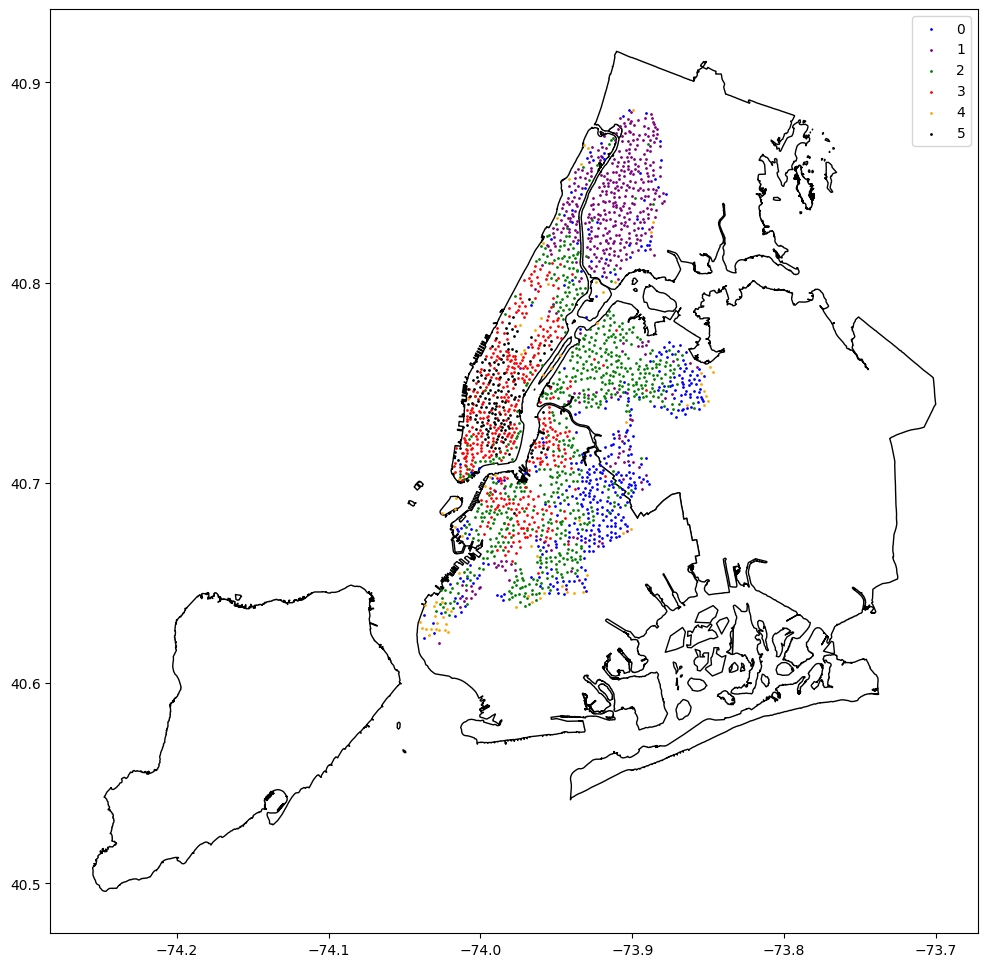

In [50]:
# Plot the data
base = gdf.plot(color='white', edgecolor='black')
colors = {0: 'blue', 1: 'purple', 2: 'green', 3: 'red', 4: 'orange', 5: 'black'}
for group, data in g_stations.groupby('kmeans_label'):
    data.plot(ax=base, marker='o', c=colors[group], markersize=1, label=group)
plt.legend()
plt.show()

### Clustering Explainability

When you're a journalist an important part of using machine learning models is being able to explain the results to your readers.

What makes these six clusters unique?

One way to figure that out is to see how they differ across the different features and then show that visually with the different clusters. Try doing this yourself. We'll talk about the steps to do it first as a class.

In [51]:
unique_stations = g_stations.loc[lambda x: x['kmeans_label'] == 5]

In [52]:
station_metadata.loc[lambda x: x['short_name'].isin(unique_stations.index)]

,capacity,station_id,short_name,name,rental_uris,lat,lon,region_id
14,51,66dd4ccc-0aca-11e7-82f6-3863bb44ef7c,7141.07,Central Park W & W 72 St,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.775794,-73.976206,71
20,96,66dc686c-0aca-11e7-82f6-3863bb44ef7c,6450.12,8 Ave & W 33 St,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.751568,-73.993769,71
50,39,66dc1d80-0aca-11e7-82f6-3863bb44ef7c,6611.02,W 37 St & 10 Ave,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.756604,-73.997901,71
59,75,09dfc0e3-a448-477c-bb3c-9467dc51ef8d,5989.02,W 15 St & 6 Ave,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.738046,-73.996430,71
68,45,66db6f2e-0aca-11e7-82f6-3863bb44ef7c,5303.08,Canal St & Rutgers St,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.714275,-73.989900,71
...,...,...,...,...,...,...,...,...
2178,55,e36b5913-8e46-4c2a-b9be-73bdf8ee548b,6925.09,2 Ave & E 72 St,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.768762,-73.958408,71
2197,61,e3470e29-934c-41f1-8fe7-82135ed2d620,6492.04,W 33 St & 10 Ave,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.753773,-73.999376,71
2201,49,66db72f1-0aca-11e7-82f6-3863bb44ef7c,5484.09,Allen St & Stanton St,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.722055,-73.989111,71
2205,48,3b530cff-dd26-4cfd-b570-a85fd53354fe,5184.08,West St & Liberty St,{'android': 'https://bkn.lft.to/lastmile_qr_sc...,40.711444,-74.014847,71


In [53]:
cluster_feature_averages = g_stations.groupby('kmeans_label')[features].mean().T

In [54]:
cluster_feature_averages

kmeans_label,0,1,2,3,4,5
total_rides_start_norm,0.037038,0.029232,0.065102,0.251347,0.051393,0.508737
pct_weekend_start,0.272182,0.221224,0.242692,0.245091,0.346336,0.236103
pct_commute_start,0.199574,0.230458,0.240967,0.254203,0.180539,0.253866
pct_electric_start,0.769932,0.890326,0.669978,0.709379,0.616923,0.684491
pct_member_start,0.720837,0.804432,0.834994,0.842289,0.627196,0.839418
average_ride_time_start_norm,0.212624,0.196902,0.177989,0.178775,0.328777,0.174113
average_ride_time_end_norm,0.367411,0.324080,0.314511,0.317731,0.560819,0.307442
total_rides_end_norm,0.036220,0.028459,0.064140,0.247451,0.051801,0.506763
pct_weekend_end,0.271342,0.219117,0.242708,0.246439,0.348849,0.235733
pct_commute_end,0.187860,0.216364,0.226484,0.248698,0.177150,0.253547


In [55]:
cluster_feature_averages['variance'] = cluster_feature_averages.apply(lambda x: x.var(), axis=1)
cluster_feature_averages.sort_values('variance', ascending=False)

kmeans_label,0,1,2,3,4,5,variance
total_rides_start_norm,0.037038,0.029232,0.065102,0.251347,0.051393,0.508737,0.036587
total_rides_end_norm,0.036220,0.028459,0.064140,0.247451,0.051801,0.506763,0.036261
average_ride_time_end_norm,0.367411,0.324080,0.314511,0.317731,0.560819,0.307442,0.009624
pct_electric_end,0.767621,0.892340,0.668658,0.709279,0.612556,0.684775,0.009493
pct_electric_start,0.769932,0.890326,0.669978,0.709379,0.616923,0.684491,0.009186
pct_member_end,0.719200,0.806714,0.838164,0.842276,0.626472,0.839362,0.007751
pct_member_start,0.720837,0.804432,0.834994,0.842289,0.627196,0.839418,0.007572
average_ride_time_start_norm,0.212624,0.196902,0.177989,0.178775,0.328777,0.174113,0.003512
pct_weekend_end,0.271342,0.219117,0.242708,0.246439,0.348849,0.235733,0.002153
pct_weekend_start,0.272182,0.221224,0.242692,0.245091,0.346336,0.236103,0.002039


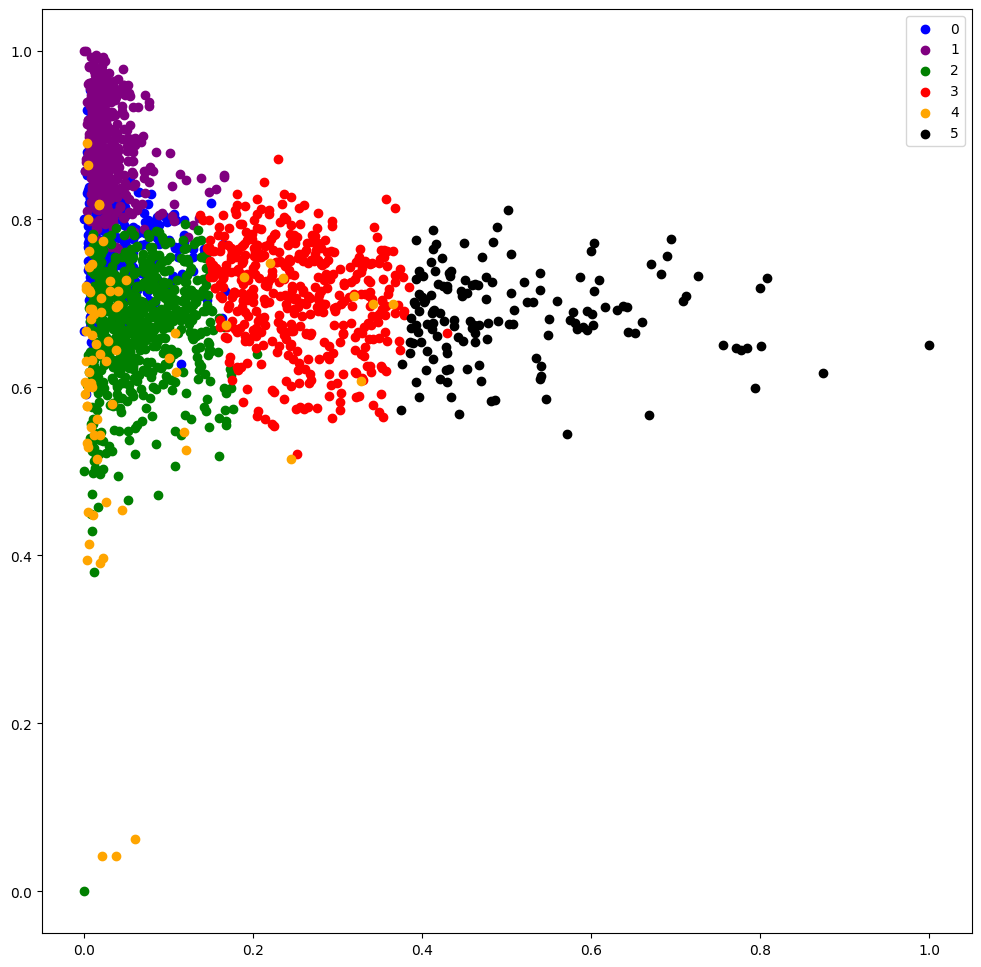

In [56]:
fig, ax = plt.subplots()

for name, group in g_stations.groupby('kmeans_label'):
    ax.scatter(group['total_rides_start_norm'], group['pct_electric_start'], c=colors[name], label=name)

plt.legend()
plt.show()

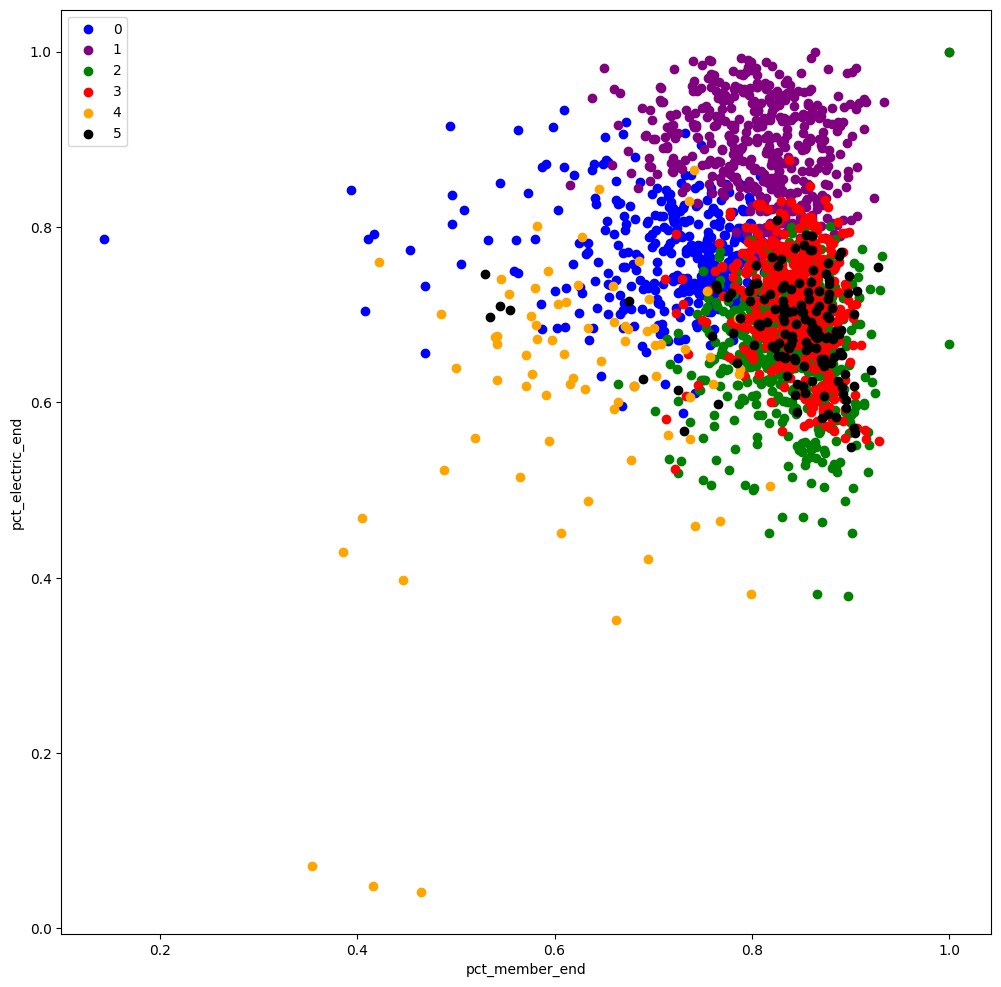

In [57]:
fig, ax = plt.subplots()

for name, group in g_stations.groupby('kmeans_label'):
    ax.scatter(group['pct_member_end'], group['pct_electric_end'], c=colors[name], label=name)

ax.set_xlabel('pct_member_end')
ax.set_ylabel('pct_electric_end')
plt.legend()
plt.show()

---

---

---